#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
path = '/content/drive/MyDrive/project6/'

### **(2) 라이브러리 설치 및 불러오기**

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten,Input,SimpleRNN,Dropout
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [149]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [150]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [151]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [152]:
from datetime import timedelta
import holidays
def make_dataset(Product_ID):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.weekday # 요일 추출 (0: 월요일, 6: 일요일)
    temp3['Month'] = temp3['Date'].dt.month
    temp3['Day']=temp3['Date'].dt.day

    # 2일뒤 요일
    temp3['Date_2']=temp3['Date']+timedelta(2)
    temp3['Day+2']=temp3['Date_2'].dt.day
    temp3['Weekday+2']=temp3['Date_2'].dt.weekday

    temp3['Qty_1ago'] = temp3['Qty'].shift(1) #1일전 매출
    temp3['Qty_2ago'] = temp3['Qty'].shift(2) #2일전 매출
    temp3['Qty_last week'] = temp3['Qty'].shift(7) #일주일전 매출

    # 평균 판매량(7일, 14일)
    temp3['MA_7'] = temp3['Qty'].rolling(window=7).mean()
    temp3['MA_14'] = temp3['Qty'].rolling(window=14).mean()

    # 판매량 변화율
    temp3['Qty_diff_1'] = temp3['Qty'].diff(1)

    # 미국 공휴일 인스턴스 생성
    us_holidays = holidays.US()
    # 미국 공휴일 여부 확인 (1: 공휴일, 0: 비공휴일)
    temp3['holiday'] = temp3['Date'].apply(lambda x: 1 if x in us_holidays else 0)

    # 주말
    temp3['weekend']=np.where(temp3['WeekDay']>=5,1,0)

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    # 결측치를 이전값과 이후값의 평균으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
    # 첫번째 또는 마지막 값이 결측치인 경우 이전/이후 값으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='ffill').fillna(method='bfill')

    temp3 = pd.merge(temp3, oil_price, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()
    temp3.dropna(inplace = True)

    return temp3


In [153]:
product03=make_dataset(3)
product03

,Date,Qty,CustomerCount,target,WeekDay,Month,Day,Date_2,Day+2,Weekday+2,...,Qty_2ago,Qty_last week,MA_7,MA_14,Qty_diff_1,holiday,weekend,Category_Qty,City_CustCount,WTI_Price
13,2014-01-15,6815.0,3872,7671.0,2,1,15,2014-01-17,17,4,...,7086.0,8800.0,8480.142857,9464.857143,994.0,0,0,7020.0,38896,92.8260
14,2014-01-16,7482.0,3781,13131.0,3,1,16,2014-01-18,18,5,...,5821.0,6606.0,8605.285714,9295.500000,667.0,0,0,7806.0,37616,92.6660
15,2014-01-17,7671.0,3953,13661.0,4,1,17,2014-01-19,19,6,...,6815.0,7051.0,8693.857143,9225.785714,189.0,0,0,8101.0,39421,92.6960
16,2014-01-18,13131.0,4950,7208.0,5,1,18,2014-01-20,20,0,...,7482.0,12599.0,8769.857143,9081.357143,5460.0,0,1,13874.0,47458,92.6960
17,2014-01-19,13661.0,4711,6778.0,6,1,19,2014-01-21,21,1,...,7671.0,13383.0,8809.571429,8942.428571,530.0,0,1,13661.0,46461,92.6960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,7856.0,3834,10208.0,2,2,22,2017-02-24,24,4,...,6004.0,7854.0,9534.857143,9913.714286,679.0,0,0,8118.0,38673,53.4275
1140,2017-02-23,8018.0,3955,12361.0,3,2,23,2017-02-25,25,5,...,7177.0,7829.0,9561.857143,9928.071429,162.0,0,0,8316.0,39881,53.5765
1141,2017-02-24,10208.0,4549,10108.0,4,2,24,2017-02-26,26,6,...,7856.0,9524.0,9659.571429,9879.571429,2190.0,0,0,10689.0,43170,53.5915
1142,2017-02-25,12361.0,4619,10006.0,5,2,25,2017-02-27,27,0,...,8018.0,16331.0,9092.428571,9785.357143,2153.0,0,1,13073.0,46801,53.5915


In [175]:
def preproc(data, y_scale = False) :
    x = product03.drop(['Date','Date_2', 'target'], axis = 1)
    y = product03.loc[:, 'target']

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['Day'] = pd.Categorical(x['Day'] ,categories=range(1, 32),ordered=True)
    x = pd.get_dummies(x, columns = ['WeekDay','Month','Day'])

    # 스케일링
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 300, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [176]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(product03, True)
y_min, y_max

(2853.0, 25413.0)

((852, 95), (285, 95), (852,), (285,))

## **(1) 상품 : 3 - Beverage**

In [177]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(random_state=42)
dtr.fit(x_train,y_train)
y_pred=dtr.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

0.094
0.071
0.233
0.576


In [178]:
from sklearn.ensemble import RandomForestRegressor
dfr=RandomForestRegressor(random_state=42)
dfr.fit(x_train,y_train)
y_pred=dfr.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

0.075
0.053
0.168
0.726


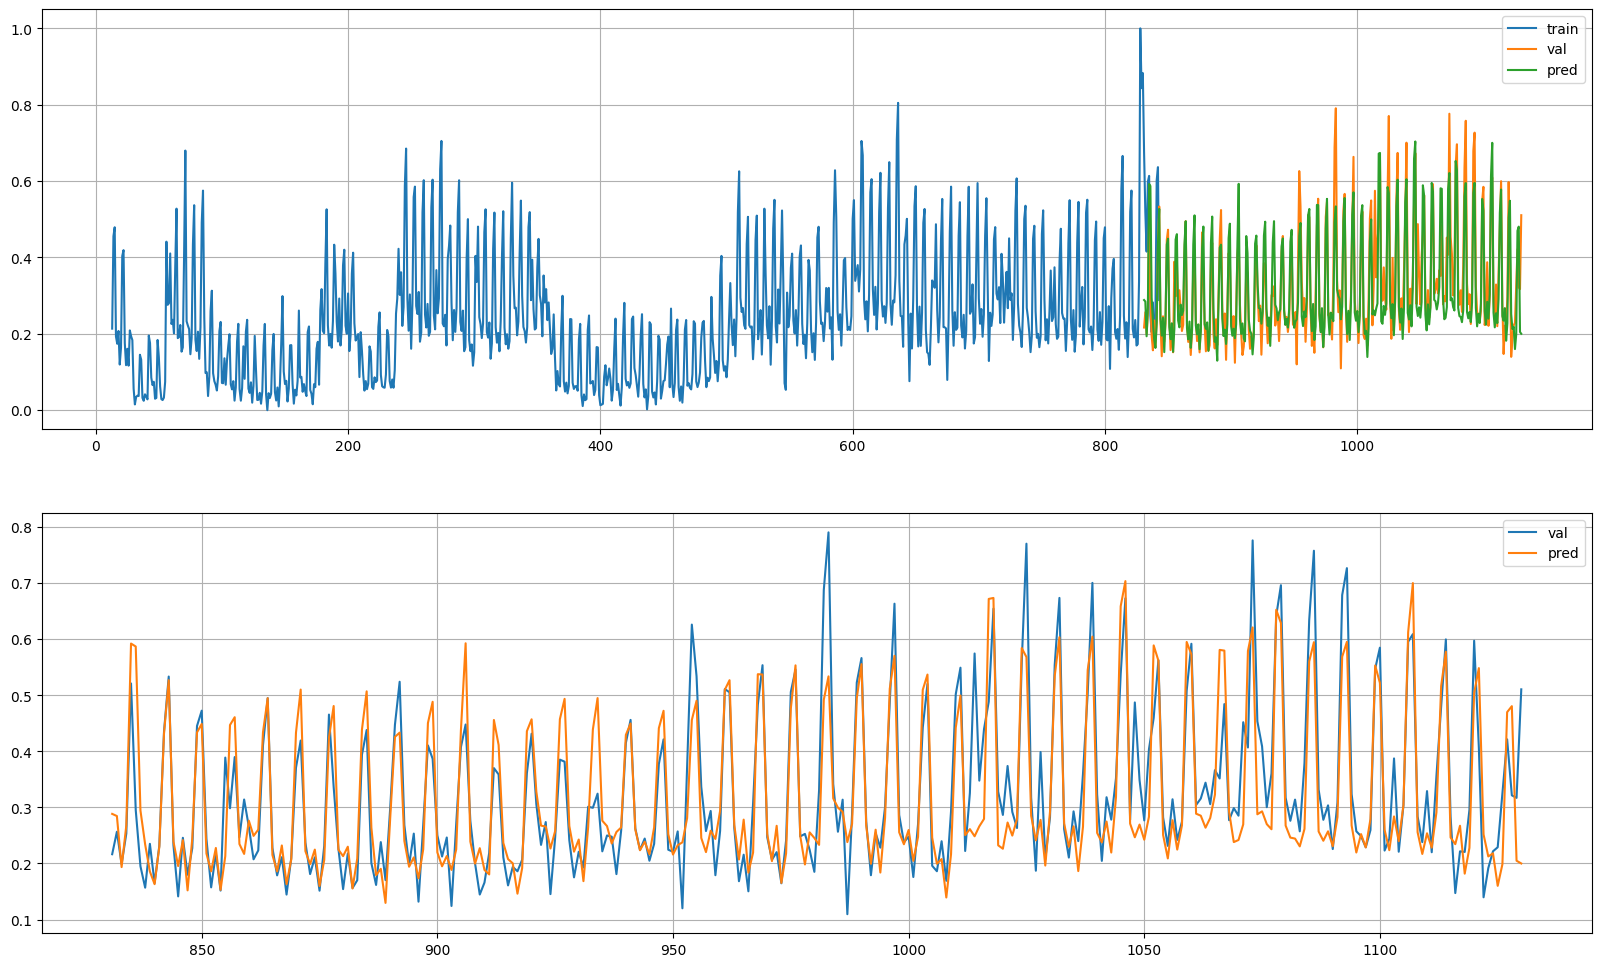

In [179]:
plot_model_result(y_train, y_val,y_pred)

In [180]:
from xgboost import XGBRegressor
xgb=XGBRegressor()
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

0.082
0.061
0.194
0.677


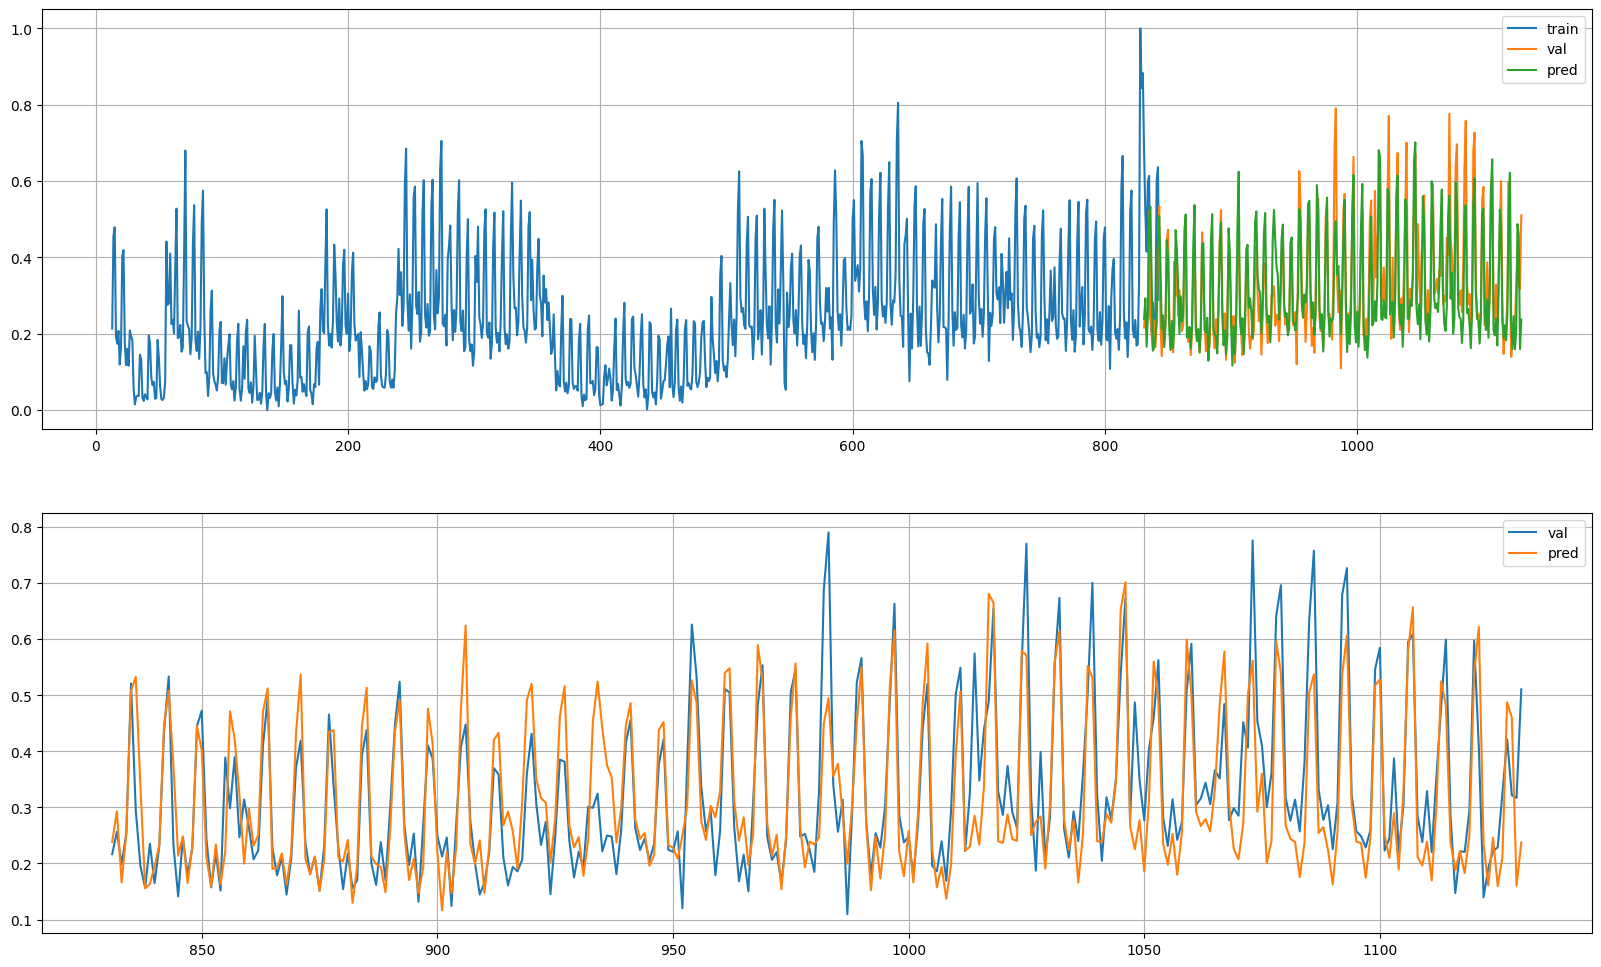

In [181]:
plot_model_result(y_train, y_val,y_pred)

In [182]:
from lightgbm import LGBMRegressor
lgb=LGBMRegressor()
lgb.fit(x_train,y_train)
y_pred=lgb.predict(x_val)
print(round(root_mean_squared_error(y_val,y_pred),3))
print(round(mean_absolute_error(y_val,y_pred),3))
print(round(mean_absolute_percentage_error(y_val,y_pred),3))
print(round(r2_score(y_val,y_pred),3))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 831, number of used features: 56
[LightGBM] [Info] Start training from score 0.236936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.083
0.061
0.197
0.665


## **(2) 상품 : 12 - Milk**

## **(3) 상품 : 42 - Agricultural products**

# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [183]:
# 기본모델
clear_session()

nfeat = x_train.shape[1]

model03_00 = Sequential([Dense(1, input_shape = (nfeat, ) )])
model03_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

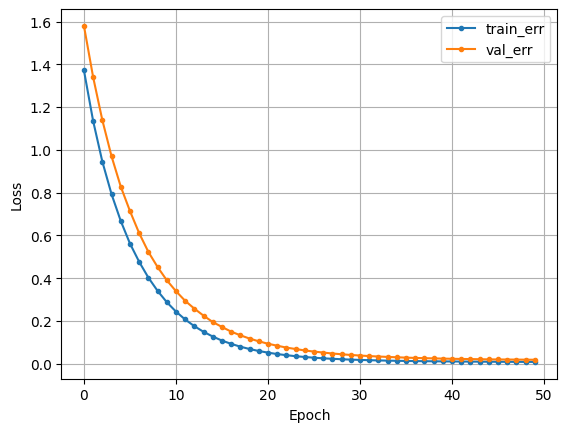

In [184]:
model03_00.compile(optimizer = 'adam', loss = 'mse')
hist = model03_00.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [185]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_00.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE :  1729.8047403971354
MAPE :  0.17194305949409214
R2 :  0.47841846687526723


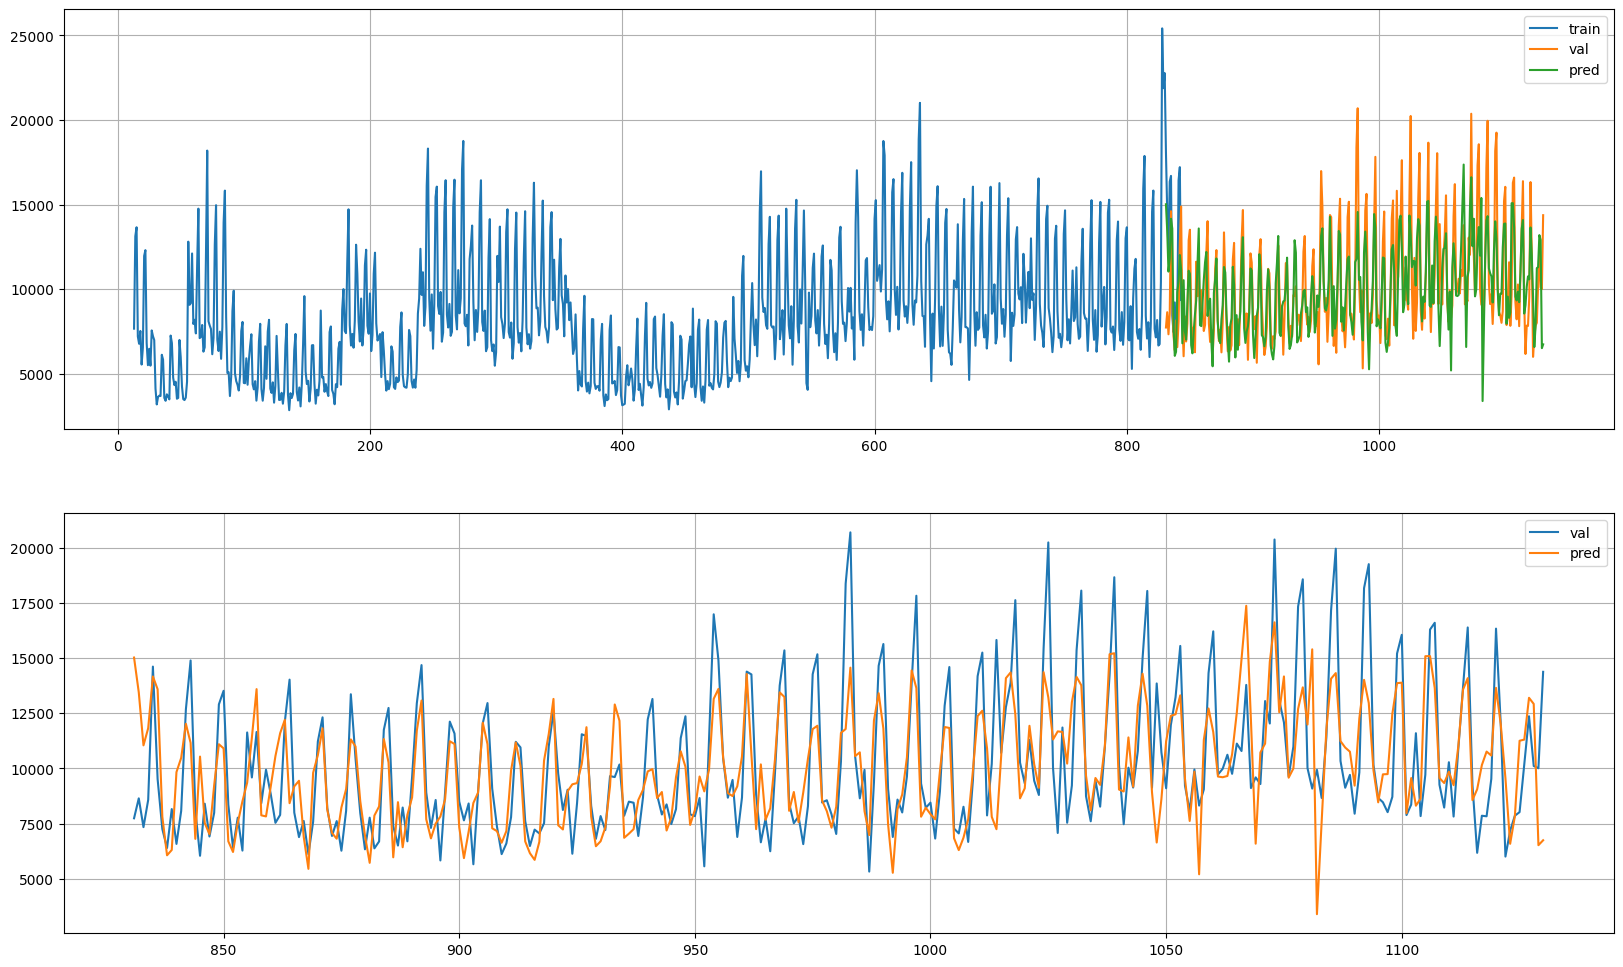

In [187]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

### **2) 모델링**

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

### **2) 모델링**

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

### **2) 모델링**

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [188]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

In [204]:
def preproc3d(data, timesteps, y_scale = False) :
    x = product03.drop(['Date','Date_2', 'target'], axis = 1)
    y = product03.loc[:, 'target']

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['Day'] = pd.Categorical(x['Day'] ,categories=range(1, 32),ordered=True)
    x = pd.get_dummies(x, columns = ['WeekDay','Month','Day'])
    col_names = list(x)


    # 스케일링
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max



### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [205]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(product03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1005, 7, 65), (120, 7, 65))

In [240]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([LSTM(16, activation='tanh',input_shape = (ts, nfeat) ),
                         Dense(1)])
model03_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,265 (20.57 KB)

 Trainable params: 5,265 (20.57 KB)

 Non-trainable params: 0 (0.00 B)

* **모델링**

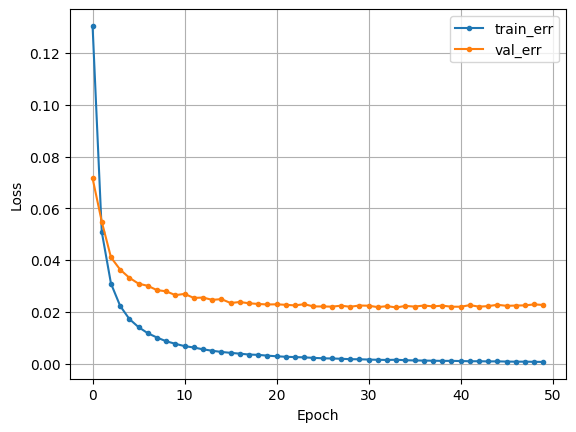

In [241]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [242]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
MAE :  3537.8858489990234
MAPE :  0.3212901738771207
R2 :  -0.6221345301411141


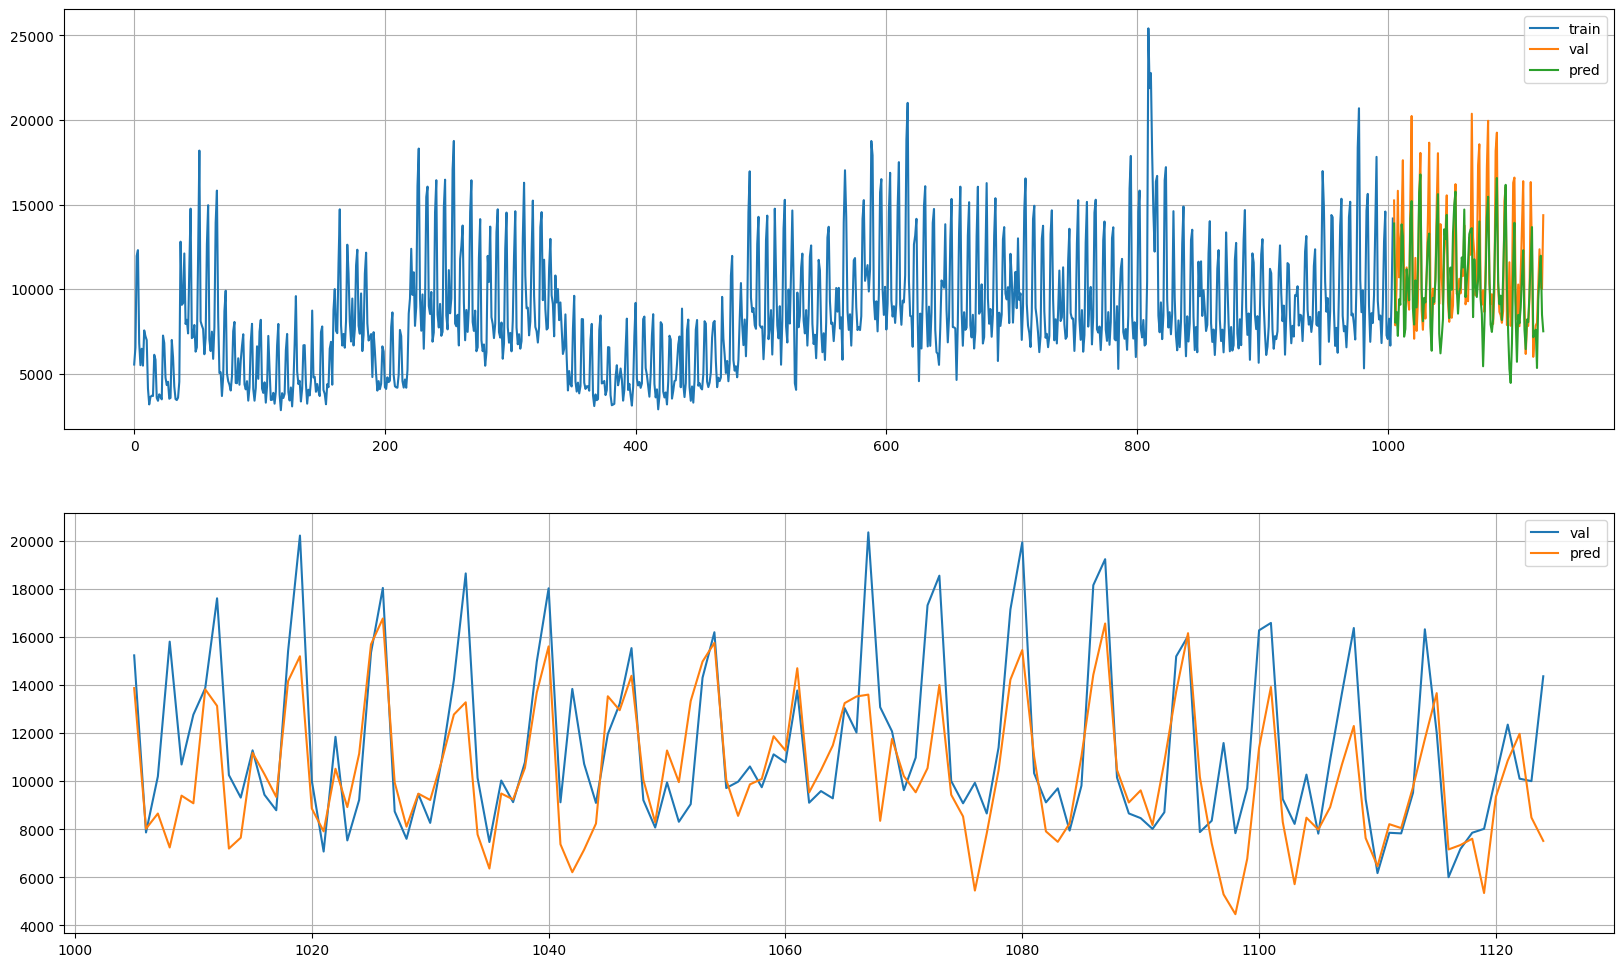

In [235]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [198]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(product03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (825, 7, 65), (300, 7, 65))

* **모델링**

In [199]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model03_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 4)                │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 813 (3.18 KB)

 Trainable params: 813 (3.18 KB)

 Non-trainable params: 0 (0.00 B)

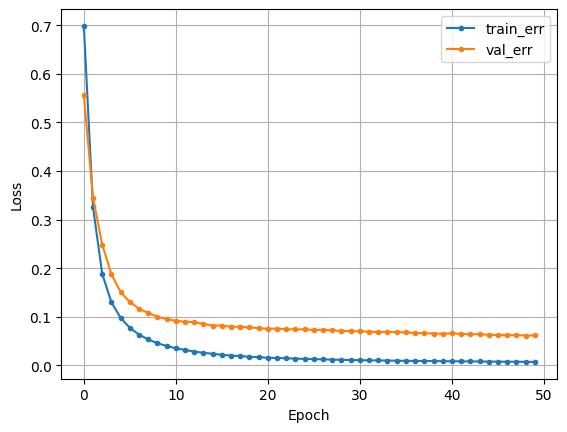

In [200]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [201]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MAE :  3427.032578938802
MAPE :  0.3507698407493588
R2 :  -0.9440024282874857


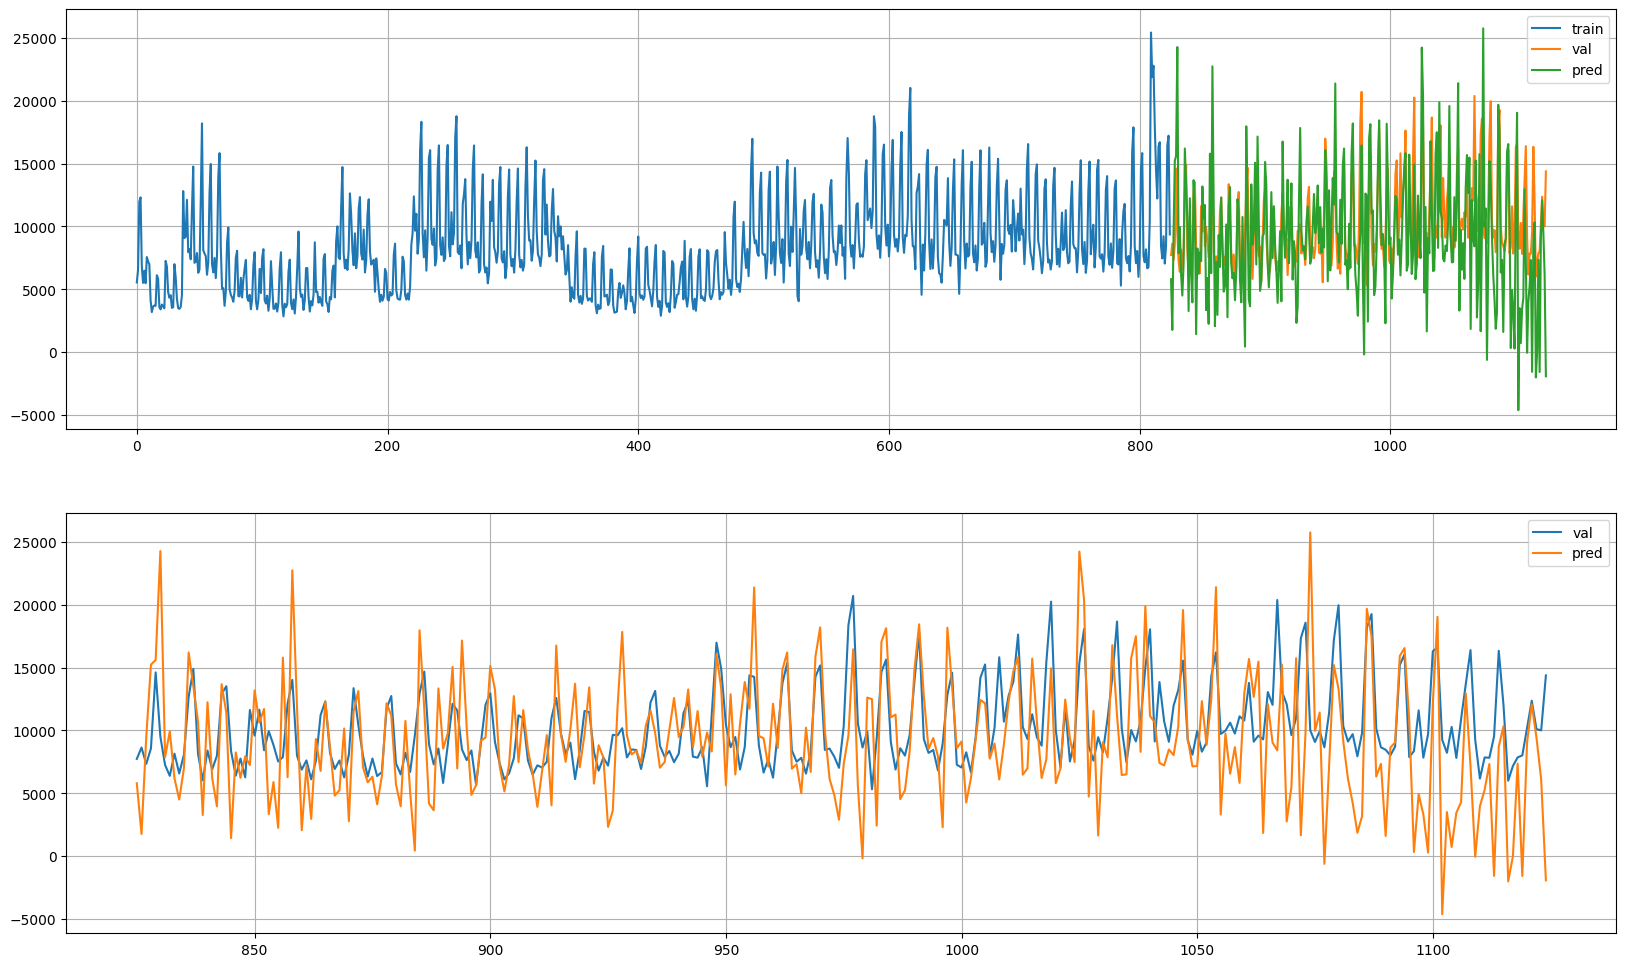

In [202]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [203]:
import joblib

joblib.dump(product03, path + 'data03.pkl')
# joblib.dump(data12, path + 'data12.pkl')
# joblib.dump(data42, path + 'data42.pkl')

['/content/drive/MyDrive/project6/data03.pkl']